In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools
import time

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
import itertools
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

from keras.applications.inception_v3 import InceptionV3

Using TensorFlow backend.


In [2]:
#1. Function to plot model's validation loss and validation accuracy
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()


In [3]:
base_skin_dir = os.path.join('C:/Users/suhas/Documents/Datacamp projects', 'Cancer')

# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

# This dictionary is useful for displaying more human-friendly labels later on

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [4]:


skin_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))

# Creating New Columns for better readability

skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes


In [5]:
# Now lets see the sample of tile_df to look on newly made columns
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,C:/Users/suhas/Documents/Datacamp projects\Can...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,C:/Users/suhas/Documents/Datacamp projects\Can...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,C:/Users/suhas/Documents/Datacamp projects\Can...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,C:/Users/suhas/Documents/Datacamp projects\Can...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,C:/Users/suhas/Documents/Datacamp projects\Can...,Benign keratosis-like lesions,2


In [6]:
skin_df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [7]:
skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)

In [8]:
skin_df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

In [9]:
print(skin_df.dtypes)

lesion_id         object
image_id          object
dx                object
dx_type           object
age              float64
sex               object
localization      object
path              object
cell_type         object
cell_type_idx       int8
dtype: object


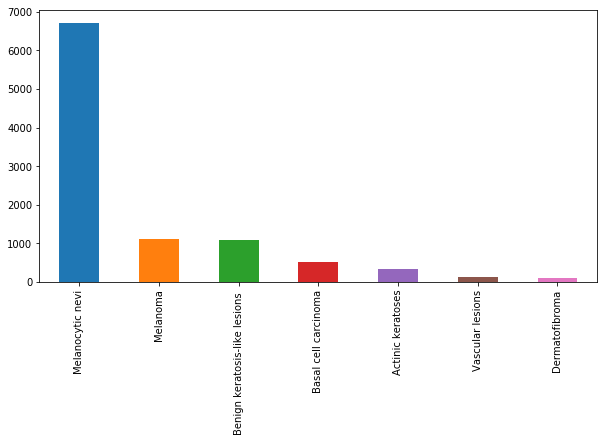

In [10]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
skin_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

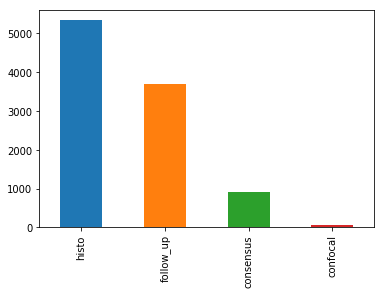

In [11]:
skin_df['dx_type'].value_counts().plot(kind='bar')

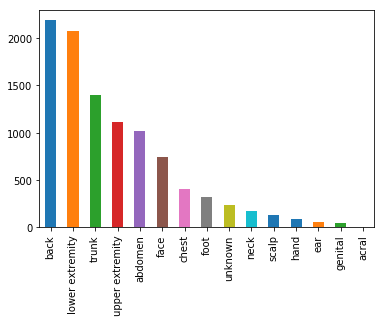

In [12]:
skin_df['localization'].value_counts().plot(kind='bar')

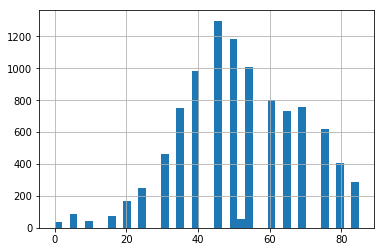

In [13]:
skin_df['age'].hist(bins=40)

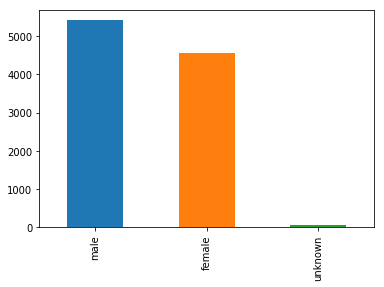

In [14]:

skin_df['sex'].value_counts().plot(kind='bar')

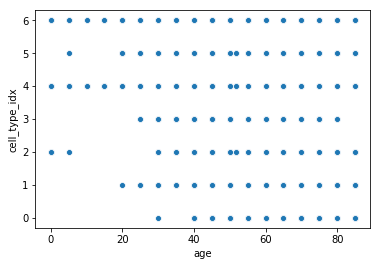

In [15]:
sns.scatterplot('age','cell_type_idx',data=skin_df)

C:\Users\suhas\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\suhas\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


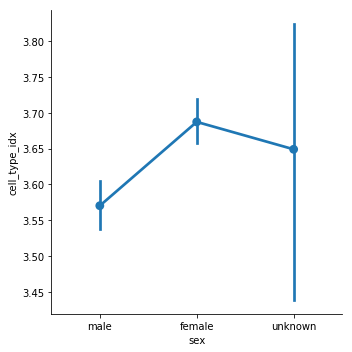

In [16]:
sns.factorplot('sex','cell_type_idx',data=skin_df)

In [17]:
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

In [18]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,C:/Users/suhas/Documents/Datacamp projects\Can...,Benign keratosis-like lesions,2,"[[[191, 153, 194], [191, 154, 198], [189, 152,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,C:/Users/suhas/Documents/Datacamp projects\Can...,Benign keratosis-like lesions,2,"[[[23, 13, 22], [25, 15, 24], [24, 16, 31], [3..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,C:/Users/suhas/Documents/Datacamp projects\Can...,Benign keratosis-like lesions,2,"[[[186, 126, 136], [190, 136, 149], [195, 137,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,C:/Users/suhas/Documents/Datacamp projects\Can...,Benign keratosis-like lesions,2,"[[[24, 11, 18], [27, 13, 26], [39, 23, 33], [6..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,C:/Users/suhas/Documents/Datacamp projects\Can...,Benign keratosis-like lesions,2,"[[[136, 91, 114], [148, 104, 127], [161, 117, ..."


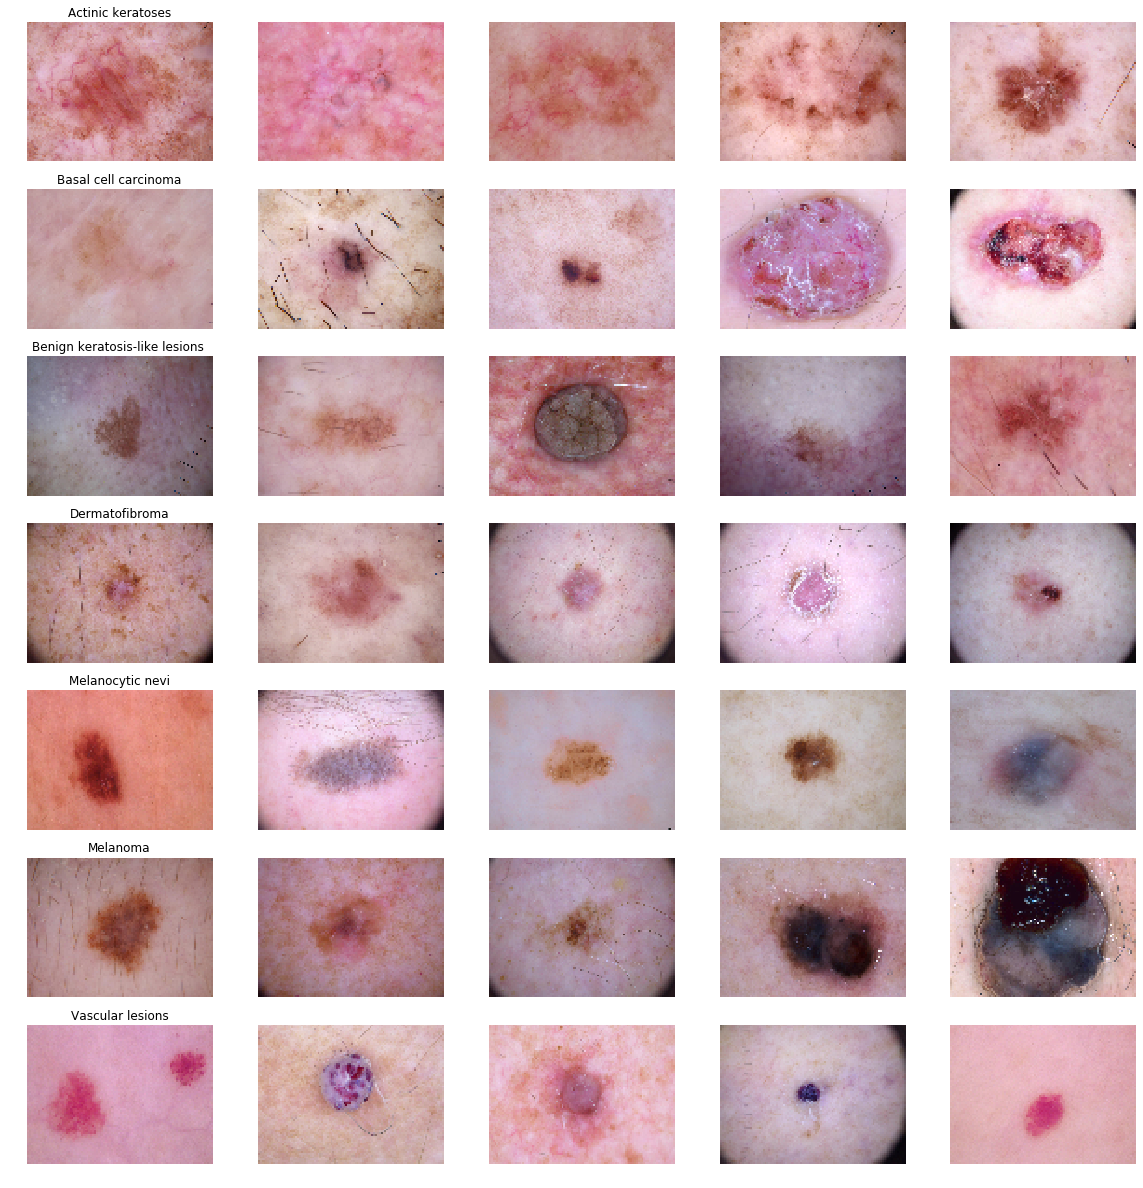

In [19]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [20]:
# Checking the image size distribution
skin_df['image'].map(lambda x: x.shape).value_counts()

(75, 100, 3)    10015
Name: image, dtype: int64

In [21]:
features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']

In [22]:
input_shape = (75, 100, 3)
num_classes = 7

In [23]:
################################
#Creating 10% training data
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.90,random_state=108)

x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std
# Perform one-hot encoding on the labels
y_train_10 = to_categorical(y_train_o, num_classes = 7)
y_test_10 = to_categorical(y_test_o, num_classes = 7)

x_train_10 = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test_10 = x_test.reshape(x_test.shape[0], *(75, 100, 3))

In [24]:
################################
#Creating 20% training data

x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.80,random_state=108)

x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std
# Perform one-hot encoding on the labels
y_train_20 = to_categorical(y_train_o, num_classes = 7)
y_test_20 = to_categorical(y_test_o, num_classes = 7)

x_train_20 = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test_20 = x_test.reshape(x_test.shape[0], *(75, 100, 3))

In [25]:
################################
#Creating 30% training data

x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.70,random_state=108)

x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std
# Perform one-hot encoding on the labels
y_train_30 = to_categorical(y_train_o, num_classes = 7)
y_test_30 = to_categorical(y_test_o, num_classes = 7)

x_train_30 = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test_30 = x_test.reshape(x_test.shape[0], *(75, 100, 3))

In [26]:
################################
#Creating 40% training data

x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.60,random_state=108)

x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std
# Perform one-hot encoding on the labels
y_train_40 = to_categorical(y_train_o, num_classes = 7)
y_test_40 = to_categorical(y_test_o, num_classes = 7)

x_train_40 = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test_40 = x_test.reshape(x_test.shape[0], *(75, 100, 3))

In [27]:
################################
#Creating 50% training data

x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.50,random_state=108)

x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std
# Perform one-hot encoding on the labels
y_train_50 = to_categorical(y_train_o, num_classes = 7)
y_test_50 = to_categorical(y_test_o, num_classes = 7)

x_train_50 = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test_50 = x_test.reshape(x_test.shape[0], *(75, 100, 3))

In [28]:
# Training the model for 10% training size
m = []
acc1 = []
start = time.time()

K.clear_session()

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
batch_size = 32
epochs = 12

history = model.fit(x_train_10, y_train_10,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test_10, y_test_10))

score = model.evaluate(x_test_10, y_test_10, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

end = time.time()

m.append(end-start)
acc1.append(score[1])

Train on 1001 samples, validate on 9014 samples
Epoch 1/12
1001/1001 [==============================] - 11s 11ms/step - loss: 2.0722 - acc: 0.6234 - val_loss: 1.1387 - val_acc: 0.6656
Epoch 2/12
1001/1001 [==============================] - 4s 4ms/step - loss: 1.0588 - acc: 0.6603 - val_loss: 1.0004 - val_acc: 0.6717
Epoch 3/12
1001/1001 [==============================] - 5s 5ms/step - loss: 0.9127 - acc: 0.6983 - val_loss: 1.0395 - val_acc: 0.6550
Epoch 4/12
1001/1001 [==============================] - 4s 4ms/step - loss: 0.8587 - acc: 0.7113 - val_loss: 0.9312 - val_acc: 0.6772
Epoch 5/12
1001/1001 [==============================] - 4s 4ms/step - loss: 0.7439 - acc: 0.7463 - val_loss: 1.1093 - val_acc: 0.6162
Epoch 6/12
1001/1001 [==============================] - 4s 4ms/step - loss: 0.6051 - acc: 0.7912 - val_loss: 0.9074 - val_acc: 0.6862
Epoch 7/12
1001/1001 [==============================] - 4s 4ms/step - loss: 0.4914 - acc: 0.8242 - val_loss: 1.0865 - val_acc: 0.6838
Epoch 8/12
1

In [29]:
# Training the model for 20% training size

start = time.time()

K.clear_session()

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
batch_size = 32
epochs = 12

history = model.fit(x_train_20, y_train_20,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test_20, y_test_20))

score = model.evaluate(x_test_20, y_test_20, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

end = time.time()

m.append(end-start)
acc1.append(score[1])

Train on 2003 samples, validate on 8012 samples
Epoch 1/12
2003/2003 [==============================] - 7s 3ms/step - loss: 2.6719 - acc: 0.6510 - val_loss: 1.0087 - val_acc: 0.6682
Epoch 2/12
2003/2003 [==============================] - 5s 3ms/step - loss: 0.9944 - acc: 0.6640 - val_loss: 1.0951 - val_acc: 0.6691
Epoch 3/12
2003/2003 [==============================] - 5s 3ms/step - loss: 0.9223 - acc: 0.6940 - val_loss: 0.9817 - val_acc: 0.6634
Epoch 4/12
2003/2003 [==============================] - 5s 3ms/step - loss: 0.8340 - acc: 0.7109 - val_loss: 0.8880 - val_acc: 0.6853
Epoch 5/12
2003/2003 [==============================] - 5s 3ms/step - loss: 0.7534 - acc: 0.7329 - val_loss: 0.8820 - val_acc: 0.6782
Epoch 6/12
2003/2003 [==============================] - 5s 3ms/step - loss: 0.6881 - acc: 0.7599 - val_loss: 0.9660 - val_acc: 0.6952
Epoch 7/12
2003/2003 [==============================] - 5s 3ms/step - loss: 0.6010 - acc: 0.7963 - val_loss: 0.9411 - val_acc: 0.7022
Epoch 8/12
200

In [30]:
# Training the model for 30% training size

start = time.time()


K.clear_session()

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
batch_size = 32
epochs = 12

history = model.fit(x_train_30, y_train_30,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test_30, y_test_30))

score = model.evaluate(x_test_30, y_test_30, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

end = time.time()

m.append(end-start)

acc1.append(score[1])

Train on 3004 samples, validate on 7011 samples
Epoch 1/12
3004/3004 [==============================] - 8s 3ms/step - loss: 1.6554 - acc: 0.6528 - val_loss: 0.9733 - val_acc: 0.6732
Epoch 2/12
3004/3004 [==============================] - 6s 2ms/step - loss: 0.8988 - acc: 0.6907 - val_loss: 0.8633 - val_acc: 0.6876
Epoch 3/12
3004/3004 [==============================] - 6s 2ms/step - loss: 0.7907 - acc: 0.7204 - val_loss: 0.8613 - val_acc: 0.7057
Epoch 4/12
3004/3004 [==============================] - 6s 2ms/step - loss: 0.7120 - acc: 0.7420 - val_loss: 0.8388 - val_acc: 0.6968
Epoch 5/12
3004/3004 [==============================] - 6s 2ms/step - loss: 0.5995 - acc: 0.7883 - val_loss: 0.8290 - val_acc: 0.7159
Epoch 6/12
3004/3004 [==============================] - 6s 2ms/step - loss: 0.4847 - acc: 0.8389 - val_loss: 0.8199 - val_acc: 0.7150
Epoch 7/12
3004/3004 [==============================] - 6s 2ms/step - loss: 0.3675 - acc: 0.8732 - val_loss: 0.8705 - val_acc: 0.7069
Epoch 8/12
300

In [31]:
# Training the model for 40% training size
start = time.time()

K.clear_session()

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
batch_size = 32
epochs = 12

history = model.fit(x_train_40, y_train_40,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test_40, y_test_40))

score = model.evaluate(x_test_40, y_test_40, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

end = time.time()

m.append(end-start)

acc1.append(score[1])

Train on 4006 samples, validate on 6009 samples
Epoch 1/12
4006/4006 [==============================] - 8s 2ms/step - loss: 1.2241 - acc: 0.6513 - val_loss: 0.9034 - val_acc: 0.6675
Epoch 2/12
4006/4006 [==============================] - 7s 2ms/step - loss: 0.8665 - acc: 0.6910 - val_loss: 0.8527 - val_acc: 0.6833
Epoch 3/12
4006/4006 [==============================] - 7s 2ms/step - loss: 0.7772 - acc: 0.7259 - val_loss: 1.0120 - val_acc: 0.7023
Epoch 4/12
4006/4006 [==============================] - 7s 2ms/step - loss: 0.6775 - acc: 0.7631 - val_loss: 0.8783 - val_acc: 0.7121
Epoch 5/12
4006/4006 [==============================] - 7s 2ms/step - loss: 0.5777 - acc: 0.7943 - val_loss: 1.0066 - val_acc: 0.7058
Epoch 6/12
4006/4006 [==============================] - 7s 2ms/step - loss: 0.4881 - acc: 0.8377 - val_loss: 0.8556 - val_acc: 0.7136
Epoch 7/12
4006/4006 [==============================] - 7s 2ms/step - loss: 0.3708 - acc: 0.8724 - val_loss: 1.2495 - val_acc: 0.6166
Epoch 8/12
400

In [32]:
# Training the model for 50% training size

start = time.time()

K.clear_session()

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
batch_size = 32
epochs = 12

history = model.fit(x_train_50, y_train_50,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test_50, y_test_50))

score = model.evaluate(x_test_50, y_test_50, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

end = time.time()

m.append(end-start)

acc1.append(score[1])

Train on 5007 samples, validate on 5008 samples
Epoch 1/12
5007/5007 [==============================] - 9s 2ms/step - loss: 1.1536 - acc: 0.6701 - val_loss: 1.0786 - val_acc: 0.6717
Epoch 2/12
5007/5007 [==============================] - 8s 2ms/step - loss: 0.8569 - acc: 0.6924 - val_loss: 0.9062 - val_acc: 0.6929
Epoch 3/12
5007/5007 [==============================] - 8s 2ms/step - loss: 0.7693 - acc: 0.7262 - val_loss: 0.8231 - val_acc: 0.7039
Epoch 4/12
5007/5007 [==============================] - 8s 2ms/step - loss: 0.6926 - acc: 0.7561 - val_loss: 0.7908 - val_acc: 0.7310
Epoch 5/12
5007/5007 [==============================] - 8s 2ms/step - loss: 0.5935 - acc: 0.7941 - val_loss: 0.7564 - val_acc: 0.7238
Epoch 6/12
5007/5007 [==============================] - 7s 1ms/step - loss: 0.4840 - acc: 0.8334 - val_loss: 0.8314 - val_acc: 0.7238
Epoch 7/12
5007/5007 [==============================] - 7s 1ms/step - loss: 0.3986 - acc: 0.8646 - val_loss: 0.8591 - val_acc: 0.7320
Epoch 8/12
500

In [34]:
# Training the VGG16 model for 10% training size
n = []
acc2 = []
start = time.time()

K.clear_session()

tmodel_base = VGG16(weights='imagenet',include_top=False,input_shape=input_shape)
augs = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

augs.fit(x_train_10)

annealer = ReduceLROnPlateau(monitor='val_loss',factor=0.2,
                            patience=3,min_lr=0.001)


tmodel = Sequential()
tmodel.add(tmodel_base)
tmodel.add(BatchNormalization())
tmodel.add(Dropout(0.50))
tmodel.add(Flatten())
tmodel.add(Dense(512,activation='relu'))
tmodel.add(BatchNormalization())
tmodel.add(Dropout(0.25))
tmodel.add(Dense(num_classes,activation='softmax',name='output_layer'))
tmodel.summary()

tmodel.compile(loss='categorical_crossentropy',
              optimizer='sgd',metrics=['accuracy'])

batch_size = 128
epochs = 30

history = tmodel.fit(x_train_10,y_train_10,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_test_10,y_test_10),
                    verbose=1)

score = tmodel.evaluate(x_test_10, y_test_10, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

end = time.time()
acc2.append(score[1])
n.append(end-start)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 3, 512)         14714688  
_________________________________________________________________
batch_normalization_1 (Batch (None, 2, 3, 512)         2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 3, 512)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1573376   
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 3, 512)         14714688  
_________________________________________________________________
batch_normalization_1 (Batch (None, 2, 3, 512)         2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 3, 512)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1573376   
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
__________

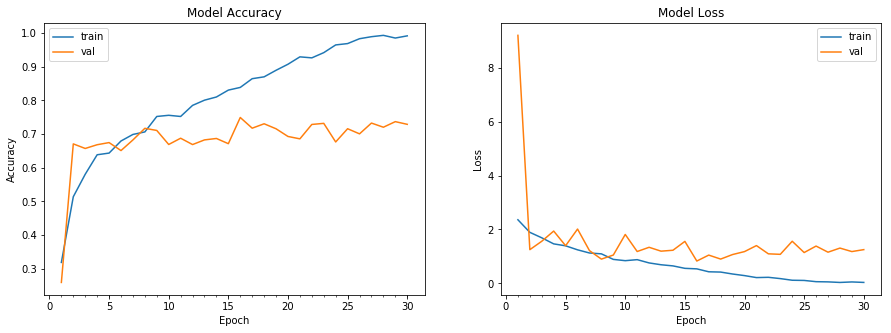

Test loss: 1.25070941623782
Test accuracy: 0.7290314527910111


In [35]:
# Training the VGG16 model for 20% training size

start = time.time()

K.clear_session()

tmodel_base = VGG16(weights='imagenet',include_top=False,input_shape=input_shape)
augs = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

augs.fit(x_train_20)

annealer = ReduceLROnPlateau(monitor='val_loss',factor=0.2,
                            patience=3,min_lr=0.001)


tmodel = Sequential()
tmodel.add(tmodel_base)
tmodel.add(BatchNormalization())
tmodel.add(Dropout(0.50))
tmodel.add(Flatten())
tmodel.add(Dense(512,activation='relu'))
tmodel.add(BatchNormalization())
tmodel.add(Dropout(0.25))
tmodel.add(Dense(num_classes,activation='softmax',name='output_layer'))
tmodel.summary()

tmodel.compile(loss='categorical_crossentropy',
              optimizer='sgd',metrics=['accuracy'])

batch_size = 128
epochs = 30

history = tmodel.fit(x_train_20,y_train_20,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_test_20,y_test_20),
                    verbose=1)

plot_model_history(history)

score = tmodel.evaluate(x_test_20, y_test_20, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

end = time.time()
acc2.append(score[1])

n.append(end-start)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 3, 512)         14714688  
_________________________________________________________________
batch_normalization_1 (Batch (None, 2, 3, 512)         2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 3, 512)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1573376   
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
__________

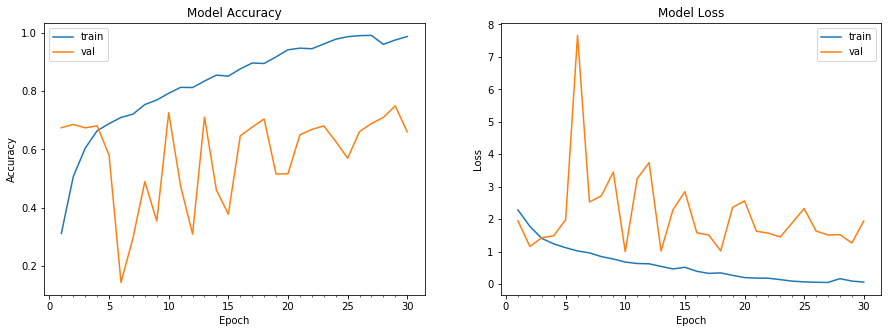

Test loss: 1.942266896660378
Test accuracy: 0.659677649408073


In [36]:
# Training the VGG16 model for 30% training size

start = time.time()

K.clear_session()

tmodel_base = VGG16(weights='imagenet',include_top=False,input_shape=input_shape)
augs = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

augs.fit(x_train_30)

annealer = ReduceLROnPlateau(monitor='val_loss',factor=0.2,
                            patience=3,min_lr=0.001)


tmodel = Sequential()
tmodel.add(tmodel_base)
tmodel.add(BatchNormalization())
tmodel.add(Dropout(0.50))
tmodel.add(Flatten())
tmodel.add(Dense(512,activation='relu'))
tmodel.add(BatchNormalization())
tmodel.add(Dropout(0.25))
tmodel.add(Dense(num_classes,activation='softmax',name='output_layer'))
tmodel.summary()

tmodel.compile(loss='categorical_crossentropy',
              optimizer='sgd',metrics=['accuracy'])

batch_size = 128
epochs = 30

history = tmodel.fit(x_train_30,y_train_30,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_test_30,y_test_30),
                    verbose=1)

plot_model_history(history)
score = tmodel.evaluate(x_test_30, y_test_30, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

end = time.time()
acc2.append(score[1])

n.append(end-start)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 3, 512)         14714688  
_________________________________________________________________
batch_normalization_1 (Batch (None, 2, 3, 512)         2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 3, 512)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1573376   
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
__________

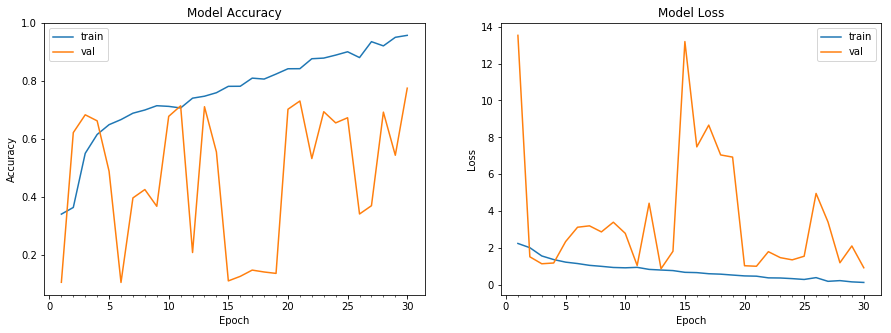

Test loss: 0.9365312781443431
Test accuracy: 0.774504909193601


In [37]:
# Training the VGG16 model for 40% training size

start = time.time()

K.clear_session()

tmodel_base = VGG16(weights='imagenet',include_top=False,input_shape=input_shape)
augs = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

augs.fit(x_train_40)

annealer = ReduceLROnPlateau(monitor='val_loss',factor=0.2,
                            patience=3,min_lr=0.001)


tmodel = Sequential()
tmodel.add(tmodel_base)
tmodel.add(BatchNormalization())
tmodel.add(Dropout(0.50))
tmodel.add(Flatten())
tmodel.add(Dense(512,activation='relu'))
tmodel.add(BatchNormalization())
tmodel.add(Dropout(0.25))
tmodel.add(Dense(num_classes,activation='softmax',name='output_layer'))
tmodel.summary()

tmodel.compile(loss='categorical_crossentropy',
              optimizer='sgd',metrics=['accuracy'])

batch_size = 128
epochs = 30

history = tmodel.fit(x_train_40,y_train_40,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_test_40,y_test_40),
                    verbose=1)

plot_model_history(history)

score = tmodel.evaluate(x_test_40, y_test_40, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

end = time.time()
acc2.append(score[1])

n.append(end-start)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 3, 512)         14714688  
_________________________________________________________________
batch_normalization_1 (Batch (None, 2, 3, 512)         2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 3, 512)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1573376   
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
__________

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x00000163B6532320>>
Traceback (most recent call last):
  File "C:\Users\suhas\Anaconda3\lib\site-packages\tensorflow\python\client\session.py", line 1415, in __del__
    self._session._session, self._handle, status)
  File "C:\Users\suhas\Anaconda3\lib\site-packages\tensorflow\python\framework\errors_impl.py", line 526, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.InvalidArgumentError: No such callable handle: 1526912909384


Train on 5007 samples, validate on 5008 samples
Epoch 1/30
5007/5007 [==============================] - 17s 3ms/step - loss: 2.1543 - acc: 0.4024 - val_loss: 15.8004 - val_acc: 0.0162
Epoch 2/30
5007/5007 [==============================] - 15s 3ms/step - loss: 1.6103 - acc: 0.6056 - val_loss: 3.8819 - val_acc: 0.2388
Epoch 3/30
5007/5007 [==============================] - 15s 3ms/step - loss: 1.3573 - acc: 0.6597 - val_loss: 1.5958 - val_acc: 0.6308
Epoch 4/30
5007/5007 [==============================] - 16s 3ms/step - loss: 1.2203 - acc: 0.6697 - val_loss: 1.0273 - val_acc: 0.6677
Epoch 5/30
5007/5007 [==============================] - 15s 3ms/step - loss: 1.1110 - acc: 0.7006 - val_loss: 1.9312 - val_acc: 0.6068
Epoch 6/30
5007/5007 [==============================] - 15s 3ms/step - loss: 1.0806 - acc: 0.7050 - val_loss: 9.5579 - val_acc: 0.2660
Epoch 7/30
5007/5007 [==============================] - 15s 3ms/step - loss: 0.9919 - acc: 0.7224 - val_loss: 1.9405 - val_acc: 0.6629
Epoch 

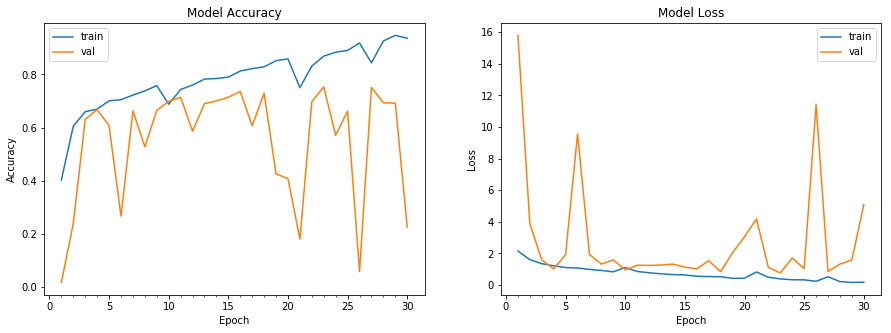

Test loss: 5.084291817662053
Test accuracy: 0.22384185303514376


In [39]:
# Training the VGG16 model for 50% training size

start = time.time()

K.clear_session()

tmodel_base = VGG16(weights='imagenet',include_top=False,input_shape=input_shape)
augs = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

augs.fit(x_train_50)

annealer = ReduceLROnPlateau(monitor='val_loss',factor=0.2,
                            patience=3,min_lr=0.001)


tmodel = Sequential()
tmodel.add(tmodel_base)
tmodel.add(BatchNormalization())
tmodel.add(Dropout(0.50))
tmodel.add(Flatten())
tmodel.add(Dense(512,activation='relu'))
tmodel.add(BatchNormalization())
tmodel.add(Dropout(0.25))
tmodel.add(Dense(num_classes,activation='softmax',name='output_layer'))
tmodel.summary()

tmodel.compile(loss='categorical_crossentropy',
              optimizer='sgd',metrics=['accuracy'])

batch_size = 128
epochs = 30

history = tmodel.fit(x_train_50,y_train_50,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_test_50,y_test_50),
                    verbose=1)

plot_model_history(history)

score = tmodel.evaluate(x_test_50, y_test_50, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


end = time.time()

acc2.append(score[1])

n.append(end-start)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 1, 1, 2048)        21802784  
_________________________________________________________________
batch_normalization_95 (Batc (None, 1, 1, 2048)        8192      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 1, 2048)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1049088   
_________________________________________________________________
batch_normalization_96 (Batc (None, 512)               2048      
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
__________

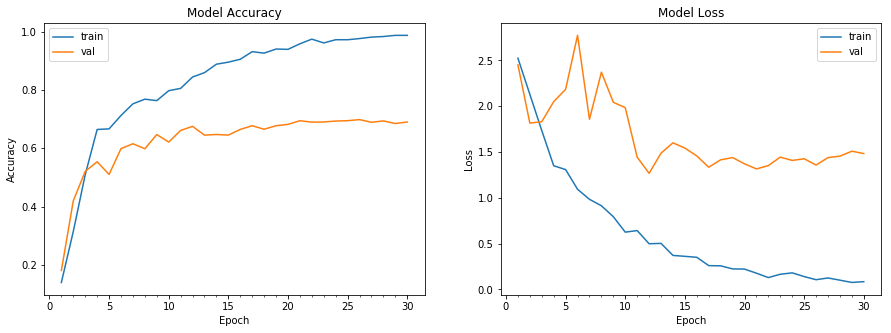

Test loss: 1.4829679159147924
Test accuracy: 0.6899267805106681


In [40]:
# Training the InceptionV3 model for 10% training size

o = []
acc3 = []
start = time.time()

K.clear_session()

model1 = InceptionV3(include_top=False, 
                     weights='imagenet', 
                     input_tensor=None, 
                     input_shape=input_shape, 
                     pooling=None, 
                     classes=num_classes)

augs1 = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

augs1.fit(x_train_10)

annealer1 = ReduceLROnPlateau(monitor='val_loss',factor=0.2,
                            patience=3,min_lr=0.001)


tmodel1 = Sequential()
tmodel1.add(model1)
tmodel1.add(BatchNormalization())
tmodel1.add(Dropout(0.50))
tmodel1.add(Flatten())
tmodel1.add(Dense(512,activation='relu'))
tmodel1.add(BatchNormalization())
tmodel1.add(Dropout(0.25))
tmodel1.add(Dense(num_classes,activation='softmax',name='output_layer'))
tmodel1.summary()

tmodel1.compile(loss='categorical_crossentropy',
              optimizer='sgd',metrics=['accuracy'])

batch_size = 128
epochs = 30

history1 = tmodel1.fit(x_train_10,y_train_10,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_test_10,y_test_10),
                    verbose=1)

plot_model_history(history1)

score = tmodel1.evaluate(x_test_10, y_test_10, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

end = time.time()
acc3.append(score[1])
o.append(end-start)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 1, 1, 2048)        21802784  
_________________________________________________________________
batch_normalization_95 (Batc (None, 1, 1, 2048)        8192      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 1, 2048)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1049088   
_________________________________________________________________
batch_normalization_96 (Batc (None, 512)               2048      
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
__________

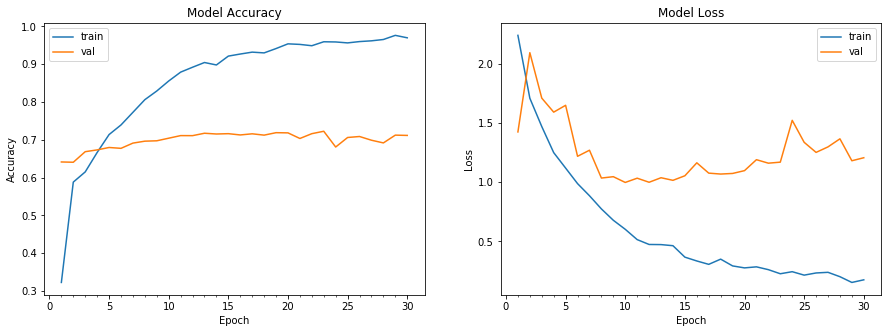

Test loss: 1.2066511069901038
Test accuracy: 0.7116824762855717


In [41]:
# Training the InceptionV3 model for 20% training size

start = time.time()

K.clear_session()

model1 = InceptionV3(include_top=False, 
                     weights='imagenet', 
                     input_tensor=None, 
                     input_shape=input_shape, 
                     pooling=None, 
                     classes=num_classes)

augs1 = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

augs1.fit(x_train_20)

annealer1 = ReduceLROnPlateau(monitor='val_loss',factor=0.2,
                            patience=3,min_lr=0.001)


tmodel1 = Sequential()
tmodel1.add(model1)
tmodel1.add(BatchNormalization())
tmodel1.add(Dropout(0.50))
tmodel1.add(Flatten())
tmodel1.add(Dense(512,activation='relu'))
tmodel1.add(BatchNormalization())
tmodel1.add(Dropout(0.25))
tmodel1.add(Dense(num_classes,activation='softmax',name='output_layer'))
tmodel1.summary()

tmodel1.compile(loss='categorical_crossentropy',
              optimizer='sgd',metrics=['accuracy'])

batch_size = 128
epochs = 30

history1 = tmodel1.fit(x_train_20,y_train_20,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_test_20,y_test_20),
                    verbose=1)

plot_model_history(history1)

score = tmodel1.evaluate(x_test_20, y_test_20, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

end = time.time()

acc3.append(score[1])
o.append(end-start)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 1, 1, 2048)        21802784  
_________________________________________________________________
batch_normalization_95 (Batc (None, 1, 1, 2048)        8192      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 1, 2048)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1049088   
_________________________________________________________________
batch_normalization_96 (Batc (None, 512)               2048      
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
__________

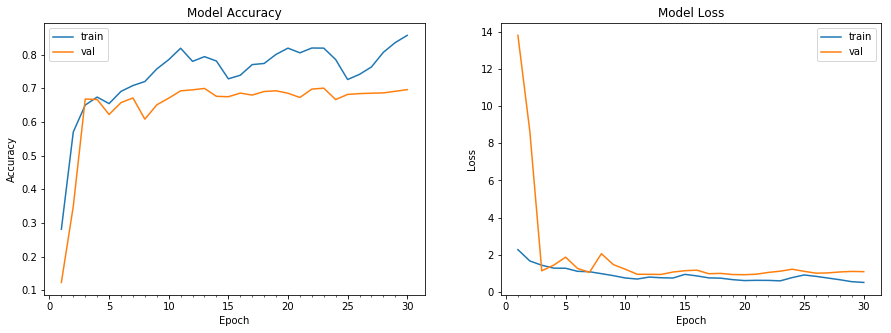

Test loss: 1.1001718454482705
Test accuracy: 0.6959064327570396


In [42]:
# Training the InceptionV3 model for 30% training size

start = time.time()

K.clear_session()

model1 = InceptionV3(include_top=False, 
                     weights='imagenet', 
                     input_tensor=None, 
                     input_shape=input_shape, 
                     pooling=None, 
                     classes=num_classes)

augs1 = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

augs1.fit(x_train_30)

annealer1 = ReduceLROnPlateau(monitor='val_loss',factor=0.2,
                            patience=3,min_lr=0.001)


tmodel1 = Sequential()
tmodel1.add(model1)
tmodel1.add(BatchNormalization())
tmodel1.add(Dropout(0.50))
tmodel1.add(Flatten())
tmodel1.add(Dense(512,activation='relu'))
tmodel1.add(BatchNormalization())
tmodel1.add(Dropout(0.25))
tmodel1.add(Dense(num_classes,activation='softmax',name='output_layer'))
tmodel1.summary()

tmodel1.compile(loss='categorical_crossentropy',
              optimizer='sgd',metrics=['accuracy'])

batch_size = 128
epochs = 30

history1 = tmodel1.fit(x_train_30,y_train_30,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_test_30,y_test_30),
                    verbose=1)

plot_model_history(history1)

score = tmodel1.evaluate(x_test_30, y_test_30, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

end = time.time()
acc3.append(score[1])

o.append(end-start)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 1, 1, 2048)        21802784  
_________________________________________________________________
batch_normalization_95 (Batc (None, 1, 1, 2048)        8192      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 1, 2048)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1049088   
_________________________________________________________________
batch_normalization_96 (Batc (None, 512)               2048      
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
__________

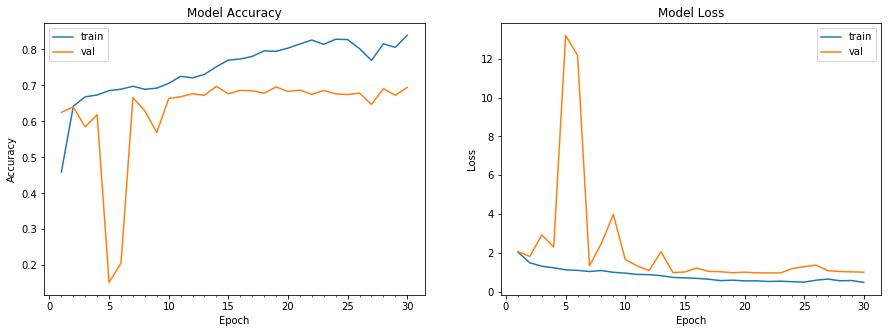

Test loss: 0.9967454075118948
Test accuracy: 0.6946247295326313


In [43]:
# Training the InceptionV3 model for 40% training size

start = time.time()

K.clear_session()

model1 = InceptionV3(include_top=False, 
                     weights='imagenet', 
                     input_tensor=None, 
                     input_shape=input_shape, 
                     pooling=None, 
                     classes=num_classes)

augs1 = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

augs1.fit(x_train_40)

annealer1 = ReduceLROnPlateau(monitor='val_loss',factor=0.2,
                            patience=3,min_lr=0.001)


tmodel1 = Sequential()
tmodel1.add(model1)
tmodel1.add(BatchNormalization())
tmodel1.add(Dropout(0.50))
tmodel1.add(Flatten())
tmodel1.add(Dense(512,activation='relu'))
tmodel1.add(BatchNormalization())
tmodel1.add(Dropout(0.25))
tmodel1.add(Dense(num_classes,activation='softmax',name='output_layer'))
tmodel1.summary()

tmodel1.compile(loss='categorical_crossentropy',
              optimizer='sgd',metrics=['accuracy'])

batch_size = 128
epochs = 30

history1 = tmodel1.fit(x_train_40,y_train_40,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_test_40,y_test_40),
                    verbose=1)

plot_model_history(history1)

score = tmodel1.evaluate(x_test_40, y_test_40, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

end = time.time()
acc3.append(score[1])

o.append(end-start)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 1, 1, 2048)        21802784  
_________________________________________________________________
batch_normalization_95 (Batc (None, 1, 1, 2048)        8192      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 1, 2048)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1049088   
_________________________________________________________________
batch_normalization_96 (Batc (None, 512)               2048      
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
__________

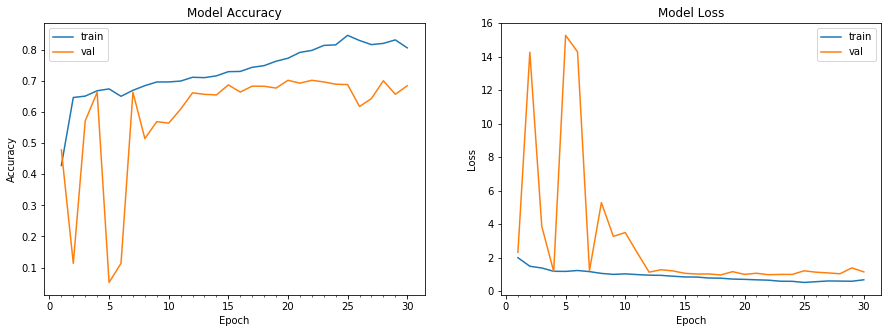

Test loss: 1.1574588358973543
Test accuracy: 0.6839057507987221


In [44]:
# Training the InceptionV3 model for 50% training size

start = time.time()

K.clear_session()

model1 = InceptionV3(include_top=False, 
                     weights='imagenet', 
                     input_tensor=None, 
                     input_shape=input_shape, 
                     pooling=None, 
                     classes=num_classes)

augs1 = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

augs1.fit(x_train_50)

annealer1 = ReduceLROnPlateau(monitor='val_loss',factor=0.2,
                            patience=3,min_lr=0.001)


tmodel1 = Sequential()
tmodel1.add(model1)
tmodel1.add(BatchNormalization())
tmodel1.add(Dropout(0.50))
tmodel1.add(Flatten())
tmodel1.add(Dense(512,activation='relu'))
tmodel1.add(BatchNormalization())
tmodel1.add(Dropout(0.25))
tmodel1.add(Dense(num_classes,activation='softmax',name='output_layer'))
tmodel1.summary()

tmodel1.compile(loss='categorical_crossentropy',
              optimizer='sgd',metrics=['accuracy'])

batch_size = 128
epochs = 30

history1 = tmodel1.fit(x_train_50,y_train_50,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_test_50,y_test_50),
                    verbose=1)

plot_model_history(history1)

score = tmodel1.evaluate(x_test_50, y_test_50, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

end = time.time()

acc3.append(score[1])

o.append(end-start)

In [46]:
from keras.applications.xception import Xception

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 3, 3, 2048)        20861480  
_________________________________________________________________
batch_normalization_5 (Batch (None, 3, 3, 2048)        8192      
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 3, 2048)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               9437696   
_________________________________________________________________
batch_normalization_6 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
__________

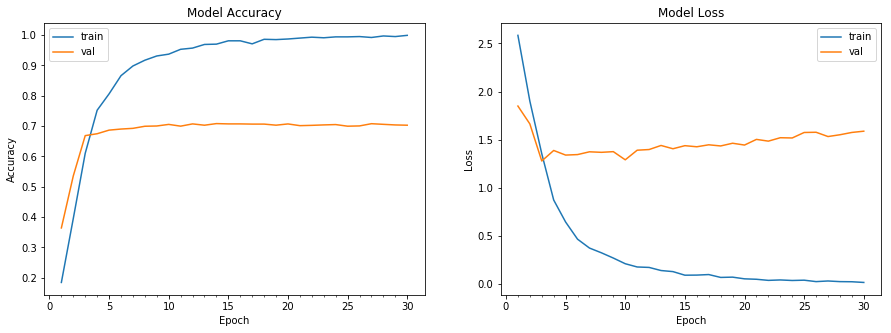

Test loss: 1.588262231910152
Test accuracy: 0.7029065896831543


In [47]:
# Training the Xception model for 10% training size
p = []
acc4 = []

start = time.time()

K.clear_session()

model2 = Xception(include_top=False, 
                  weights='imagenet', 
                  input_tensor=None, 
                  input_shape=input_shape, 
                  pooling=None, 
                  classes=num_classes)
augs2 = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

augs2.fit(x_train_10)

annealer2 = ReduceLROnPlateau(monitor='val_loss',factor=0.2,
                            patience=3,min_lr=0.001)
tmodel2 = Sequential()
tmodel2.add(model2)
tmodel2.add(BatchNormalization())
tmodel2.add(Dropout(0.50))
tmodel2.add(Flatten())
tmodel2.add(Dense(512,activation='relu'))
tmodel2.add(BatchNormalization())
tmodel2.add(Dropout(0.25))
tmodel2.add(Dense(num_classes,activation='softmax',name='output_layer'))
tmodel2.summary()

tmodel2.compile(loss='categorical_crossentropy',
              optimizer='sgd',metrics=['accuracy'])

batch_size = 128
epochs = 30

history2 = tmodel2.fit(x_train_10,y_train_10,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_test_10,y_test_10),
                    verbose=1)

plot_model_history(history2)
score = tmodel2.evaluate(x_test_10, y_test_10, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

end = time.time()
acc4.append(score[1])
p.append(end-start)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 3, 3, 2048)        20861480  
_________________________________________________________________
batch_normalization_5 (Batch (None, 3, 3, 2048)        8192      
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 3, 2048)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               9437696   
_________________________________________________________________
batch_normalization_6 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
__________

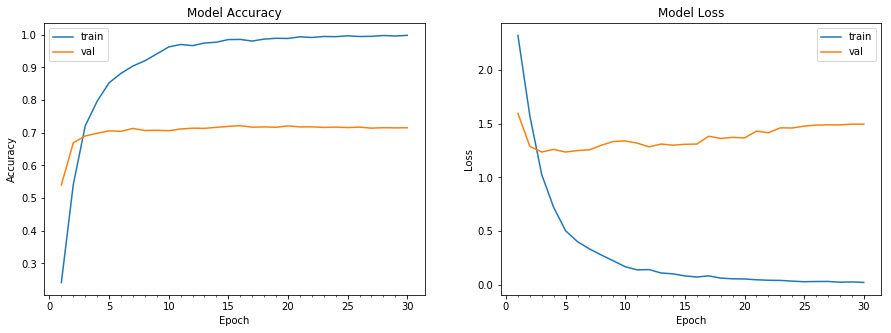

Test loss: 1.4947689531805273
Test accuracy: 0.7151772341785345


In [48]:
# Training the Xception model for 20% training size

start = time.time()

K.clear_session()

model2 = Xception(include_top=False, 
                  weights='imagenet', 
                  input_tensor=None, 
                  input_shape=input_shape, 
                  pooling=None, 
                  classes=num_classes)
augs2 = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

augs2.fit(x_train_20)

annealer2 = ReduceLROnPlateau(monitor='val_loss',factor=0.2,
                            patience=3,min_lr=0.001)
tmodel2 = Sequential()
tmodel2.add(model2)
tmodel2.add(BatchNormalization())
tmodel2.add(Dropout(0.50))
tmodel2.add(Flatten())
tmodel2.add(Dense(512,activation='relu'))
tmodel2.add(BatchNormalization())
tmodel2.add(Dropout(0.25))
tmodel2.add(Dense(num_classes,activation='softmax',name='output_layer'))
tmodel2.summary()

tmodel2.compile(loss='categorical_crossentropy',
              optimizer='sgd',metrics=['accuracy'])

batch_size = 128
epochs = 30

history2 = tmodel2.fit(x_train_20,y_train_20,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_test_20,y_test_20),
                    verbose=1)

plot_model_history(history2)

end = time.time()
score = tmodel2.evaluate(x_test_20, y_test_20, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

acc4.append(score[1])
p.append(end-start)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 3, 3, 2048)        20861480  
_________________________________________________________________
batch_normalization_5 (Batch (None, 3, 3, 2048)        8192      
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 3, 2048)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               9437696   
_________________________________________________________________
batch_normalization_6 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
__________

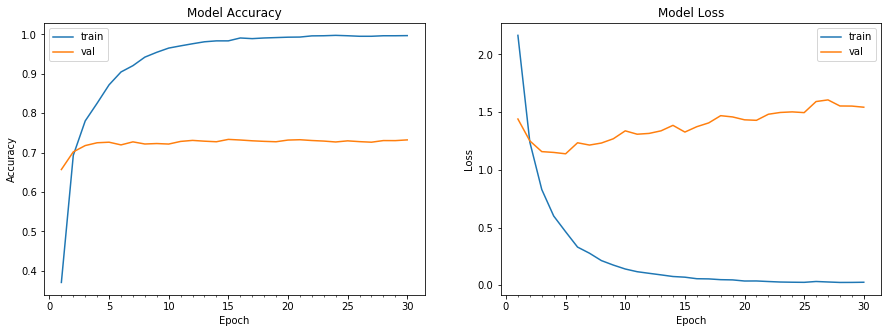

Test loss: 1.5429138793247257
Test accuracy: 0.732135216089003


In [49]:
# Training the Xception model for 30% training size

start = time.time()

K.clear_session()

model2 = Xception(include_top=False, 
                  weights='imagenet', 
                  input_tensor=None, 
                  input_shape=input_shape, 
                  pooling=None, 
                  classes=num_classes)
augs2 = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

augs2.fit(x_train_30)

annealer2 = ReduceLROnPlateau(monitor='val_loss',factor=0.2,
                            patience=3,min_lr=0.001)
tmodel2 = Sequential()
tmodel2.add(model2)
tmodel2.add(BatchNormalization())
tmodel2.add(Dropout(0.50))
tmodel2.add(Flatten())
tmodel2.add(Dense(512,activation='relu'))
tmodel2.add(BatchNormalization())
tmodel2.add(Dropout(0.25))
tmodel2.add(Dense(num_classes,activation='softmax',name='output_layer'))
tmodel2.summary()

tmodel2.compile(loss='categorical_crossentropy',
              optimizer='sgd',metrics=['accuracy'])

batch_size = 128
epochs = 30

history2 = tmodel2.fit(x_train_30,y_train_30,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_test_30,y_test_30),
                    verbose=1)

plot_model_history(history2)

score = tmodel2.evaluate(x_test_30, y_test_30, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

end = time.time()

acc4.append(score[1])

p.append(end-start)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 3, 3, 2048)        20861480  
_________________________________________________________________
batch_normalization_5 (Batch (None, 3, 3, 2048)        8192      
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 3, 2048)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               9437696   
_________________________________________________________________
batch_normalization_6 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
__________

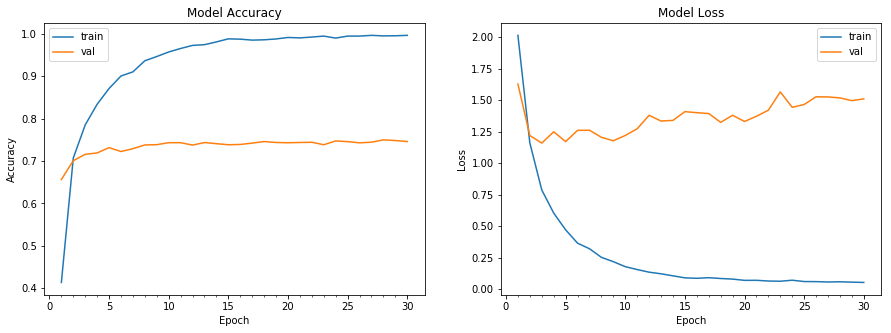

Test loss: 1.5099331211539866
Test accuracy: 0.7457147612411421


In [50]:
# Training the Xception model for 40% training size

start = time.time()

K.clear_session()

model2 = Xception(include_top=False, 
                  weights='imagenet', 
                  input_tensor=None, 
                  input_shape=input_shape, 
                  pooling=None, 
                  classes=num_classes)
augs2 = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

augs2.fit(x_train_10)

annealer2 = ReduceLROnPlateau(monitor='val_loss',factor=0.2,
                            patience=3,min_lr=0.001)
tmodel2 = Sequential()
tmodel2.add(model2)
tmodel2.add(BatchNormalization())
tmodel2.add(Dropout(0.50))
tmodel2.add(Flatten())
tmodel2.add(Dense(512,activation='relu'))
tmodel2.add(BatchNormalization())
tmodel2.add(Dropout(0.25))
tmodel2.add(Dense(num_classes,activation='softmax',name='output_layer'))
tmodel2.summary()

tmodel2.compile(loss='categorical_crossentropy',
              optimizer='sgd',metrics=['accuracy'])

batch_size = 128
epochs = 30

history2 = tmodel2.fit(x_train_40,y_train_40,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_test_40,y_test_40),
                    verbose=1)

plot_model_history(history2)

score = tmodel2.evaluate(x_test_40, y_test_40, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

end = time.time()
acc4.append(score[1])

p.append(end-start)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 3, 3, 2048)        20861480  
_________________________________________________________________
batch_normalization_5 (Batch (None, 3, 3, 2048)        8192      
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 3, 2048)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               9437696   
_________________________________________________________________
batch_normalization_6 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
__________

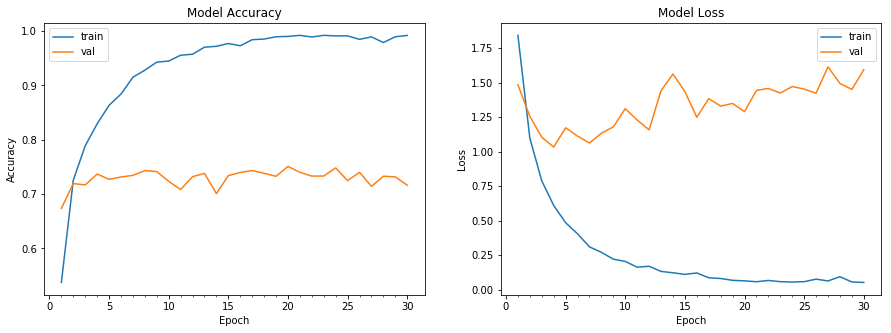

Test loss: 1.5935625108286215
Test accuracy: 0.7162539936102237


In [51]:
# Training the Xception model for 50% training size

start = time.time()

K.clear_session()

model2 = Xception(include_top=False, 
                  weights='imagenet', 
                  input_tensor=None, 
                  input_shape=input_shape, 
                  pooling=None, 
                  classes=num_classes)
augs2 = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

augs2.fit(x_train_50)

annealer2 = ReduceLROnPlateau(monitor='val_loss',factor=0.2,
                            patience=3,min_lr=0.001)
tmodel2 = Sequential()
tmodel2.add(model2)
tmodel2.add(BatchNormalization())
tmodel2.add(Dropout(0.50))
tmodel2.add(Flatten())
tmodel2.add(Dense(512,activation='relu'))
tmodel2.add(BatchNormalization())
tmodel2.add(Dropout(0.25))
tmodel2.add(Dense(num_classes,activation='softmax',name='output_layer'))
tmodel2.summary()

tmodel2.compile(loss='categorical_crossentropy',
              optimizer='sgd',metrics=['accuracy'])

batch_size = 128
epochs = 30

history2 = tmodel2.fit(x_train_50,y_train_50,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_test_50,y_test_50),
                    verbose=1)

plot_model_history(history2)

score = tmodel2.evaluate(x_test_50, y_test_50, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

end = time.time()

acc4.append(score[1])

p.append(end-start)

In [52]:
# plotting

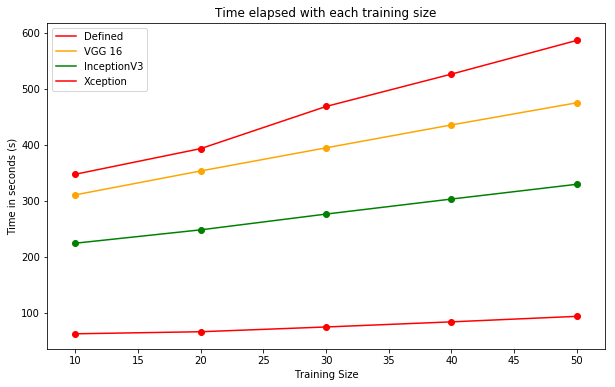

In [65]:
plt.figure(figsize = (10,6))
plt.title("Time elapsed with each training size")
plt.plot([10,20,30,40,50], m,color = 'red', label = 'Defined')
plt.scatter([10,20,30,40,50], m,color = 'red')
plt.plot([10,20,30,40,50], n, label = 'VGG 16', color = 'orange')
plt.scatter([10,20,30,40,50], n, color = 'orange')
plt.plot([10,20,30,40,50], o, label = 'InceptionV3', color = 'green')
plt.scatter([10,20,30,40,50], o, color = 'green')
plt.plot([10,20,30,40,50], p, label = 'Xception', color ='red')
plt.scatter([10,20,30,40,50], p, color = 'red')
plt.xlabel('Training Size')
plt.ylabel('Time in seconds (s)')
plt.legend()
plt.show()

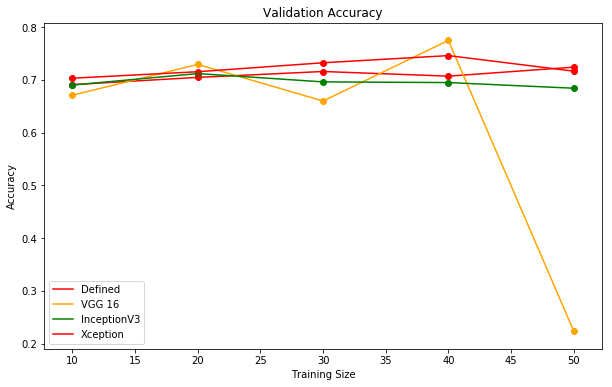

In [67]:
plt.figure(figsize = (10,6))
plt.title("Validation Accuracy")
plt.plot([10,20,30,40,50], acc1, label = 'Defined', color ='red')
plt.scatter([10,20,30,40,50], acc1,color = 'red')
plt.plot([10,20,30,40,50], acc2, label = 'VGG 16', color = 'orange')
plt.scatter([10,20,30,40,50], acc2, color = 'orange')
plt.plot([10,20,30,40,50],acc3, label = 'InceptionV3', color = 'green')
plt.scatter([10,20,30,40,50], acc3, color = 'green')
plt.plot([10,20,30,40,50], acc4, label = 'Xception', color = 'red')
plt.scatter([10,20,30,40,50], acc4, color ='red')
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.legend()
plt.show()